# **Import Libraries**

In [ ]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import TFMT5EncoderModel, AutoTokenizer



import tensorflow as tf
from tensorflow import keras


from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


seed=42
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-2-b93f3f7342db>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.expand_frame_repr', False)  # Display DataFrame in a single frame

# EDA

In [ ]:
class Datapreprocessing:


    def __init__(self,file_path,max_length):
        self.max_length = max_length
        self.file_path = file_path



    def dataframe(self):
        with open(self.file_path) as f:
            text_li = f.readlines()
        en_text = []
        zh_text = []
        en_sentence_center = []
        zh_sentence_center = []
        en_align_text = []
        zh_align_text = []
        label_text = []
        en_align_index = []
        zh_align_index = []
        pair_list1 = []
        pair_list2 = []

        for i, line in enumerate(text_li):
            if i%4== 0:
                en_text.append(line.strip())
            elif i%4 ==1:
                zh_text.append(line.strip())
            elif i%4==2:
                en_align = line.strip().split(':')[0]
                zh_align = line.strip().split(':')[-1]
                en_align_text.append(en_align)
                zh_align_text.append(zh_align)
            elif i%4==3:
                lanel_line = line.split(':')[1]
                label_text.append(lanel_line.strip())
        for en, zh, en_sent,zh_sent in zip(en_align_text, zh_align_text, en_text, zh_text):
            pair1 = en + '[SEP]' + zh + '[SEP]' + en_sent+ '[SEP]' + zh_sent
            pair_list1.append(pair1)
        for en, en_sent in zip(en_align_text, en_text):
            pair2 = en + '[SEP]' + en_sent
            pair_list2.append(pair2)








        data = {
        'en_sent': en_text,
        'zh_sent': zh_text,
        'en_align': en_align_text,
        'zh_align': zh_align_text,
        'pair1':pair_list1,
        'pair2':pair_list2,
        'label': label_text}

        df = pd.DataFrame(data)

        return df



    def test1_df(self):
        with open(self.file_path,encoding='latin-1') as q:
            text_li = q.readlines()
        text_list = []
        label_list = []

        for all in text_li:
            text = all.split('@')[0]
            label = all.split('@')[1].strip()
            text_list.append(text)
            label_list.append(label)
        data = {
            'sent': text_list,
            'label':label_list
        }
        df = pd.DataFrame(data)
        return df



file_path = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/data2/task2_train.txt'
file_path_test = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/data2/task2_test.txt'

max_len = 512
df = Datapreprocessing(file_path, max_len)
df_train = df.dataframe()
print(df_train.head(5))

df_test = Datapreprocessing(file_path_test, max_len)
df_test = df_test.dataframe()
print(df_test.head(5))

                                             en_sent                                            zh_sent en_align zh_align                                              pair1                                              pair2        label
0  It told investors that the securities bundled ...      高盛告诉投资者组成CDO的合成证券ABACUS是由独立的“抵押品管理人”ACA公司挑选的。   ABACUS   ABACUS  ABACUS[SEP]ABACUS[SEP]It told investors that t...  ABACUS[SEP]It told investors that the securiti...  equivalence
1  The EU has said the system has thrived on easy...       EU已经表示，该系统已蓬勃发展，但环境可疑的项目如工业气体减排项目及其制度应该加强管理。       EU       EU  EU[SEP]EU[SEP]The EU has said the system has t...  EU[SEP]The EU has said the system has thrived ...  equivalence
2  In vitro meat, the development of which PETA U...  培养肉——PETA US提供帮助资金的研究成果——将会让数十亿动物从所有养殖场的残酷、运输中...  PETA US  PETA US  PETA US[SEP]PETA US[SEP]In vitro meat, the dev...  PETA US[SEP]In vitro meat, the development of ...  equivalence
3  Ha, but the abbot is Shiyongxin, not you. He i...

In [ ]:
df_train.head()


,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,It told investors that the securities bundled ...,高盛告诉投资者组成CDO的合成证券ABACUS是由独立的“抵押品管理人”ACA公司挑选的。,ABACUS,ABACUS,ABACUS[SEP]ABACUS[SEP]It told investors that t...,ABACUS[SEP]It told investors that the securiti...,equivalence
1,The EU has said the system has thrived on easy...,EU已经表示，该系统已蓬勃发展，但环境可疑的项目如工业气体减排项目及其制度应该加强管理。,EU,EU,EU[SEP]EU[SEP]The EU has said the system has t...,EU[SEP]The EU has said the system has thrived ...,equivalence
2,"In vitro meat, the development of which PETA U...",培养肉——PETA US提供帮助资金的研究成果——将会让数十亿动物从所有养殖场的残酷、运输中...,PETA US,PETA US,"PETA US[SEP]PETA US[SEP]In vitro meat, the dev...","PETA US[SEP]In vitro meat, the development of ...",equivalence
3,"Ha, but the abbot is Shiyongxin, not you. He i...",哈，但是方丈是释永信啊，不是你，他已经很时尚了，他把SHAOLIN变成了一个现代的地方，和以...,SHAOLIN,SHAOLIN,"SHAOLIN[SEP]SHAOLIN[SEP]Ha, but the abbot is S...","SHAOLIN[SEP]Ha, but the abbot is Shiyongxin, n...",equivalence
4,"The WHO emblem, name and abbreviation are also...",同时保护WHO会徽、名称和缩写避免根据保护工业产权巴黎公约第6条被注册为商标。,WHO,WHO,"WHO[SEP]WHO[SEP]The WHO emblem, name and abbre...","WHO[SEP]The WHO emblem, name and abbreviation ...",equivalence


In [ ]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,I also want to say that it is important for us to,我还想说:它重要的是我们,it,它,it[SEP]它[SEP]I also want to say that it is imp...,it[SEP]I also want to say that it is important...,unaligned_reduction
1,But her advice to others is to pride yourself ...,不过她给大家提出的建议是，为自己的坦然自豪。,pride,自豪,pride[SEP]自豪[SEP]But her advice to others is t...,pride[SEP]But her advice to others is to pride...,transposition
2,To “acknowledge” someone means to recognize th...,“acknowledge”某个人意思是知道某个人在那里。通常靠眼神交流你好，即使你没有时间和...,hello,你好,hello[SEP]你好[SEP]To “acknowledge” someone mean...,hello[SEP]To “acknowledge” someone means to re...,generalization
3,Biotech companies will soon perform their own ...,根据一项新的联邦计划，生物技术公司不久就将开展确定他们的基因改良种子对环境是否安全的为目的的研究。,safe,安全的,safe[SEP]安全的[SEP]Biotech companies will soon p...,safe[SEP]Biotech companies will soon perform t...,transposition
4,"Churchyard gully freely, on any account rises ...",境内沟壑纵横，高低起伏，地表破裂高。,broken up,破裂高,"broken up[SEP]破裂高[SEP]Churchyard gully freely,...","broken up[SEP]Churchyard gully freely, on any ...",equivalence


In [ ]:
print('Train shape:',df_train.shape)
print('Test shape:',df_test.shape)

Train shape: (60337, 7)
Test shape: (6890, 7)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60337 entries, 0 to 60336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   en_sent   60337 non-null  object
 1   zh_sent   60337 non-null  object
 2   en_align  60337 non-null  object
 3   zh_align  60337 non-null  object
 4   pair1     60337 non-null  object
 5   pair2     60337 non-null  object
 6   label     60337 non-null  object
dtypes: object(7)
memory usage: 3.2+ MB


In [ ]:
label_counts = df_train.label.value_counts()
total_samples = len(df_train)
label_percentages = label_counts #/ total_samples
print(label_percentages)

transposition               14161
generalization              10491
unaligned_reduction          8098
unaligned_explicitation      8035
particularization            5840
equivalence                  4938
modulation                   3761
lexical_shift                2666
modulation_transposition     2347
Name: label, dtype: int64


In [ ]:
label_counts = df_test.label.value_counts()
total_samples = len(df_test)
label_percentages = label_counts #/ total_samples
print(label_percentages)

transposition               1543
generalization               987
unaligned_reduction          947
unaligned_explicitation      935
particularization            667
equivalence                  629
modulation                   523
lexical_shift                333
modulation_transposition     326
Name: label, dtype: int64


In [ ]:
def sentiment_categories(category):
    if category=='literal':
        return 0
    elif category=='transposition':
        return 1
    elif category=='unaligned_explicitation':
        return 2
    elif category=='unaligned_reduction':
        return 3
    elif category=='lexical_shift':
        return 4
    elif category=='equivalence':
        return 5
    elif category=='generalization':
        return 6
    elif category=='modulation':
        return 7
    elif category=='particularization':
        return 8
    elif category=='modulation_transposition':
        return 9


In [ ]:
df_train['label']=df_train['label'].apply(sentiment_categories)


In [ ]:
df_train.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,It told investors that the securities bundled ...,高盛告诉投资者组成CDO的合成证券ABACUS是由独立的“抵押品管理人”ACA公司挑选的。,ABACUS,ABACUS,ABACUS[SEP]ABACUS[SEP]It told investors that t...,ABACUS[SEP]It told investors that the securiti...,5
1,The EU has said the system has thrived on easy...,EU已经表示，该系统已蓬勃发展，但环境可疑的项目如工业气体减排项目及其制度应该加强管理。,EU,EU,EU[SEP]EU[SEP]The EU has said the system has t...,EU[SEP]The EU has said the system has thrived ...,5
2,"In vitro meat, the development of which PETA U...",培养肉——PETA US提供帮助资金的研究成果——将会让数十亿动物从所有养殖场的残酷、运输中...,PETA US,PETA US,"PETA US[SEP]PETA US[SEP]In vitro meat, the dev...","PETA US[SEP]In vitro meat, the development of ...",5
3,"Ha, but the abbot is Shiyongxin, not you. He i...",哈，但是方丈是释永信啊，不是你，他已经很时尚了，他把SHAOLIN变成了一个现代的地方，和以...,SHAOLIN,SHAOLIN,"SHAOLIN[SEP]SHAOLIN[SEP]Ha, but the abbot is S...","SHAOLIN[SEP]Ha, but the abbot is Shiyongxin, n...",5
4,"The WHO emblem, name and abbreviation are also...",同时保护WHO会徽、名称和缩写避免根据保护工业产权巴黎公约第6条被注册为商标。,WHO,WHO,"WHO[SEP]WHO[SEP]The WHO emblem, name and abbre...","WHO[SEP]The WHO emblem, name and abbreviation ...",5


In [ ]:
df_test['label']=df_test['label'].apply(sentiment_categories)

In [ ]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,I also want to say that it is important for us to,我还想说:它重要的是我们,it,它,it[SEP]它[SEP]I also want to say that it is imp...,it[SEP]I also want to say that it is important...,3
1,But her advice to others is to pride yourself ...,不过她给大家提出的建议是，为自己的坦然自豪。,pride,自豪,pride[SEP]自豪[SEP]But her advice to others is t...,pride[SEP]But her advice to others is to pride...,1
2,To “acknowledge” someone means to recognize th...,“acknowledge”某个人意思是知道某个人在那里。通常靠眼神交流你好，即使你没有时间和...,hello,你好,hello[SEP]你好[SEP]To “acknowledge” someone mean...,hello[SEP]To “acknowledge” someone means to re...,6
3,Biotech companies will soon perform their own ...,根据一项新的联邦计划，生物技术公司不久就将开展确定他们的基因改良种子对环境是否安全的为目的的研究。,safe,安全的,safe[SEP]安全的[SEP]Biotech companies will soon p...,safe[SEP]Biotech companies will soon perform t...,1
4,"Churchyard gully freely, on any account rises ...",境内沟壑纵横，高低起伏，地表破裂高。,broken up,破裂高,"broken up[SEP]破裂高[SEP]Churchyard gully freely,...","broken up[SEP]Churchyard gully freely, on any ...",5


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/mt5-large")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
tweet_len=[]
for text in df_test.pair1:
    tokens=tokenizer.encode(text,max_length=512)
    tweet_len.append(len(tokens))
print(max(tweet_len))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


512


<ipython-input-19-aa8050e070b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_len)


Text(0.5, 0, 'Number of words')

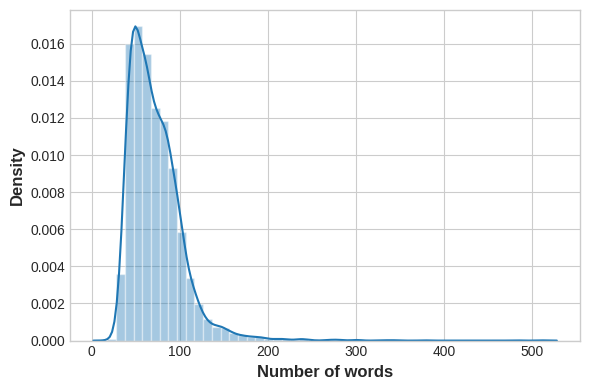

In [ ]:
f,ax=plt.subplots(figsize=(6,4))
sns.distplot(tweet_len)
plt.xlabel('Number of words')

In [ ]:
df_train=df_train[['pair1','pair2','label']]


In [ ]:
df_train.head()

,pair1,pair2,label
0,ABACUS[SEP]ABACUS[SEP]It told investors that t...,ABACUS[SEP]It told investors that the securiti...,5
1,EU[SEP]EU[SEP]The EU has said the system has t...,EU[SEP]The EU has said the system has thrived ...,5
2,"PETA US[SEP]PETA US[SEP]In vitro meat, the dev...","PETA US[SEP]In vitro meat, the development of ...",5
3,"SHAOLIN[SEP]SHAOLIN[SEP]Ha, but the abbot is S...","SHAOLIN[SEP]Ha, but the abbot is Shiyongxin, n...",5
4,"WHO[SEP]WHO[SEP]The WHO emblem, name and abbre...","WHO[SEP]The WHO emblem, name and abbreviation ...",5


In [ ]:
df_test=df_test[['pair1','pair2','label']]

In [ ]:
df_test.head()

,pair1,pair2,label
0,it[SEP]它[SEP]I also want to say that it is imp...,it[SEP]I also want to say that it is important...,3
1,pride[SEP]自豪[SEP]But her advice to others is t...,pride[SEP]But her advice to others is to pride...,1
2,hello[SEP]你好[SEP]To “acknowledge” someone mean...,hello[SEP]To “acknowledge” someone means to re...,6
3,safe[SEP]安全的[SEP]Biotech companies will soon p...,safe[SEP]Biotech companies will soon perform t...,1
4,"broken up[SEP]破裂高[SEP]Churchyard gully freely,...","broken up[SEP]Churchyard gully freely, on any ...",5


# Cleaning the Tweets

In [ ]:
#shuffle train data and reset index
df_train=df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,pair1,pair2,label
0,Iraqi[SEP]伊拉克的[SEP]The deal comes shortly befo...,Iraqi[SEP]The deal comes shortly before the Ir...,1
1,[SEP][SEP]This would surely be a stab in the b...,[SEP]This would surely be a stab in the back.,2
2,"[SEP][SEP]'Until very recently, we had to make...","[SEP]'Until very recently, we had to make some...",2
3,human[SEP]人类的[SEP]But the amorous avian appear...,human[SEP]But the amorous avian appears to hav...,1
4,"[SEP][SEP]In word processing, movement of the ...","[SEP]In word processing, movement of the writi...",2


In [ ]:
df_test=df_test.sample(frac=1).reset_index(drop=True)
df_test.head()

,pair1,pair2,label
0,responsible[SEP]负责的[SEP]The whole viewing area...,responsible[SEP]The whole viewing area was div...,1
1,prompted[SEP]发出的[SEP]All these have prompted t...,prompted[SEP]All these have prompted the defec...,6
2,them[SEP]他们[SEP]Many people figure a few beers...,them[SEP]Many people figure a few beers at a b...,8
3,abscess[SEP]腹泻[SEP]A liver abscess will requir...,abscess[SEP]A liver abscess will require tube ...,9
4,the freezing cold[SEP]是的冰冻冷[SEP]Aren't you afr...,the freezing cold[SEP]Aren't you afraid of the...,5


In [ ]:
df_train.label.value_counts()

1    14161
6    10491
3     8098
2     8035
8     5840
5     4938
7     3761
4     2666
9     2347
Name: label, dtype: int64

# Splitting the data into train/valid/test

In [ ]:
X1=df_train['pair1'].values
# X2=df_train['pair2'].values
y=df_train['label'].values

In [ ]:
# X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1,X2,y,test_size=0.1,stratify=y,random_state=42)
X1_train,X1_val,y_train,y_val=train_test_split(X1,y,test_size=0.1,stratify=y,random_state=42)

In [ ]:
X1_test=df_test['pair1'].values
y_test=df_test['label'].values

In [ ]:
y_train_label=y_train.copy()
y_val_label=y_val.copy()
y_test_label=y_test.copy()

In [ ]:
hotencoder=preprocessing.OneHotEncoder()
y_train=hotencoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val=hotencoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test=hotencoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Model2: BERT Model

In [ ]:
MAX_LEN=512

In [ ]:
def tokenize(tweets,max_len=MAX_LEN):
    input_ids=[]
    attention_masks=[]
    for i in range(len(tweets)):
        encoding=tokenizer.encode_plus(tweets[i],truncation=True,add_special_tokens=True,max_length=MAX_LEN,
                                       padding='max_length',return_attention_mask=True)
        if len(encoding['input_ids']) != 512:
            print(len(encoding['input_ids']))
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)


In [ ]:
train1_input_ids,train1_attention_masks=tokenize(X1_train,MAX_LEN)
test1_input_ids,test1_attention_masks=tokenize(X1_test,MAX_LEN)
val1_input_ids,val1_attention_masks=tokenize(X1_val,MAX_LEN)

# train2_input_ids,train2_attention_masks=tokenize(X2_train,MAX_LEN)
# test2_input_ids,test2_attention_masks=tokenize(X2_test,MAX_LEN)
# val2_input_ids,val2_attention_masks=tokenize(X2_val,MAX_LEN)

In [ ]:
t5_model=TFMT5EncoderModel.from_pretrained("google/mt5-large")

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at google/mt5-large were not used when initializing TFMT5EncoderModel: ['decoder', 'lm_head']
- This IS expected if you are initializing TFMT5EncoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMT5EncoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the l

In [ ]:
def create_model(bert_model,max_len=MAX_LEN):

    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05)
    loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    accuracy=tf.keras.metrics.CategoricalAccuracy()

    input_ids=tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings=bert_model(input_ids)[0]
    flattened_embeddings = tf.keras.layers.Flatten()(embeddings)
    output=tf.keras.layers.Dense(9,activation='softmax')(flattened_embeddings)
    model=tf.keras.models.Model(inputs=[input_ids],outputs=output)
    model.compile(optimizer,loss=loss_fn,metrics=accuracy)

    return model


In [ ]:
model=create_model(t5_model,MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 tfmt5_encoder_model (TFMT5E  TFBaseModelOutput(last_h  564446720
 ncoderModel)                idden_state=(None, 512,             
                             1024),                              
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 9)                 4718601   
                                                                 
Total params: 569,165,321
Trainable params: 569,165,321
Non-t

In [ ]:
config = t5_model.config

# Check the number of encoder layers
num_encoder_layers = config.num_layers
print("Number of Encoder Layers:", num_encoder_layers)

Number of Encoder Layers: 24


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
# custom_objects = {'TFMT5EncoderModel': TFMT5EncoderModel}

# # Load the existing model with custom objects
# with tf.keras.utils.custom_object_scope(custom_objects):
#     model = load_model('/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/save_checkpoints/TFt5_model.h5')



initial_l2_regularization = 0.01

def dynamic_l2_regularization(epoch):
    if epoch < 2:
        return 0
    elif epoch >= 2 and epoch <= 3 :
        return initial_l2_regularization
    elif epoch > 3:
        return initial_l2_regularization * 0.1  # Update the regularization strength after epoch 10



# Custom callback to update L2 regularization strength during training
class L2RegularizationUpdater(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        l2_regularization = dynamic_l2_regularization(epoch)
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                layer.kernel_regularizer = regularizers.l2(l2_regularization)
        print(f"L2 regularization strength: {l2_regularization}")



checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/save_checkpoints/TFmt5_best_checkpoint.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Metric to monitor (e.g., validation accuracy)
    save_best_only=True,     # Save only the best checkpoint
    mode='max'               # Mode for comparison (e.g., maximize the metric)
)

def learning_rate_scheduler(epoch, learning_rate):
    if epoch < 3:
        return learning_rate  # Keep the initial learning rate for the first 10 epochs
    else:
        return learning_rate * tf.math.exp(-0.1)  # Decrease the learning rate exponentially

l2_callback = L2RegularizationUpdater()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train1_input_ids,
    y_train,
    validation_data=([val1_input_ids], y_val),
    epochs=50,
    batch_size=4,
    callbacks=[early_stop, checkpoint, lr_scheduler, l2_callback]  # Pass the early_stop callback
)



L2 regularization strength: 0
Epoch 1/50
13576/13576 [==============================] - ETA: 0s - loss: 0.8768 - categorical_accuracy: 0.6919

13576/13576 [==============================] - 2716s 196ms/step - loss: 0.8768 - categorical_accuracy: 0.6919 - val_loss: 0.5188 - val_categorical_accuracy: 0.8015 - lr: 1.0000e-05
L2 regularization strength: 0
Epoch 2/50
13576/13576 [==============================] - ETA: 0s - loss: 0.4491 - categorical_accuracy: 0.8352

13576/13576 [==============================] - 2622s 193ms/step - loss: 0.4491 - categorical_accuracy: 0.8352 - val_loss: 0.3828 - val_categorical_accuracy: 0.8578 - lr: 1.0000e-05
L2 regularization strength: 0.01
Epoch 3/50
13576/13576 [==============================] - ETA: 0s - loss: 0.3189 - categorical_accuracy: 0.8851

13576/13576 [==============================] - 2625s 193ms/step - loss: 0.3189 - categorical_accuracy: 0.8851 - val_loss: 0.3043 - val_categorical_accuracy: 0.8901 - lr: 1.0000e-05
L2 regularization strength: 0.01
Epoch 4/50
13576/13576 [==============================] - ETA: 0s - loss: 0.2377 - categorical_accuracy: 0.9171

13576/13576 [==============================] - 2626s 193ms/step - loss: 0.2377 - categorical_accuracy: 0.9171 - val_loss: 0.2595 - val_categorical_accuracy: 0.9123 - lr: 9.0484e-06
L2 regularization strength: 0.001
Epoch 5/50
13576/13576 [==============================] - ETA: 0s - loss: 0.1657 - categorical_accuracy: 0.9431

13576/13576 [==============================] - 2627s 194ms/step - loss: 0.1657 - categorical_accuracy: 0.9431 - val_loss: 0.2530 - val_categorical_accuracy: 0.9178 - lr: 8.1873e-06
L2 regularization strength: 0.001
Epoch 6/50
13576/13576 [==============================] - ETA: 0s - loss: 0.1171 - categorical_accuracy: 0.9602

13576/13576 [==============================] - 2629s 194ms/step - loss: 0.1171 - categorical_accuracy: 0.9602 - val_loss: 0.2278 - val_categorical_accuracy: 0.9289 - lr: 7.4082e-06
L2 regularization strength: 0.001
Epoch 7/50
13576/13576 [==============================] - ETA: 0s - loss: 0.0831 - categorical_accuracy: 0.9732

13576/13576 [==============================] - 2628s 194ms/step - loss: 0.0831 - categorical_accuracy: 0.9732 - val_loss: 0.2313 - val_categorical_accuracy: 0.9311 - lr: 6.7032e-06
L2 regularization strength: 0.001
Epoch 8/50
13576/13576 [==============================] - ETA: 0s - loss: 0.0591 - categorical_accuracy: 0.9806

13576/13576 [==============================] - 2625s 193ms/step - loss: 0.0591 - categorical_accuracy: 0.9806 - val_loss: 0.2537 - val_categorical_accuracy: 0.9301 - lr: 6.0653e-06
L2 regularization strength: 0.001
Epoch 9/50
13576/13576 [==============================] - ETA: 0s - loss: 0.0411 - categorical_accuracy: 0.9871

13576/13576 [==============================] - 2628s 194ms/step - loss: 0.0411 - categorical_accuracy: 0.9871 - val_loss: 0.2578 - val_categorical_accuracy: 0.9359 - lr: 5.4881e-06


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/6_post-editing/save_checkpoints/TFt5_model.h5')

In [ ]:
res=model.predict([test1_input_ids])

216/216 [==============================] - 79s 343ms/step


In [ ]:
output_task1 = res  # Predictions for task 1
# output_task2 = res[1]  # Predictions for task 2

y_pred_task1 = np.zeros_like(output_task1)
y_pred_task1[np.arange(len(y_pred_task1)), output_task1.argmax(1)] = 1

# y_pred_task2 = np.zeros_like(output_task2)
# y_pred_task2[np.arange(len(y_pred_task2)), output_task2.argmax(1)] = 1

In [ ]:
confusion_matrix(y_test.argmax(1),y_pred_task1.argmax(1))

array([[1510,    0,    0,    0,    3,   22,    0,    3,    5],
       [   0,  935,    0,    0,    0,    0,    0,    0,    0],
       [   2,    0,  939,    0,    1,    2,    0,    1,    2],
       [   0,    0,    0,  333,    0,    0,    0,    0,    0],
       [  17,    0,    1,    0,  559,   31,    7,    5,    9],
       [  61,    0,    4,    0,   10,  874,    2,   16,   20],
       [   5,    0,    2,   14,   25,    5,  462,    7,    3],
       [  30,    0,    5,    0,    5,   90,    3,  526,    8],
       [  53,    0,    7,    0,    3,   53,    2,    7,  201]])

In [ ]:
class_labels=['transposition','unaligned_explicitation','unaligned_reduction','lexical_shift','equivalence','generalization','modulation','particularization','modulation_transposition']


In [ ]:
# mT5  post-editing task2
print(classification_report(y_test.argmax(1),y_pred_task1.argmax(1),target_names=class_labels))

                          precision    recall  f1-score   support

           transposition       0.90      0.98      0.94      1543
 unaligned_explicitation       1.00      1.00      1.00       935
     unaligned_reduction       0.98      0.99      0.99       947
           lexical_shift       0.96      1.00      0.98       333
             equivalence       0.92      0.89      0.91       629
          generalization       0.81      0.89      0.85       987
              modulation       0.97      0.88      0.92       523
       particularization       0.93      0.79      0.85       667
modulation_transposition       0.81      0.62      0.70       326

                accuracy                           0.92      6890
               macro avg       0.92      0.89      0.90      6890
            weighted avg       0.92      0.92      0.92      6890



<Axes: >

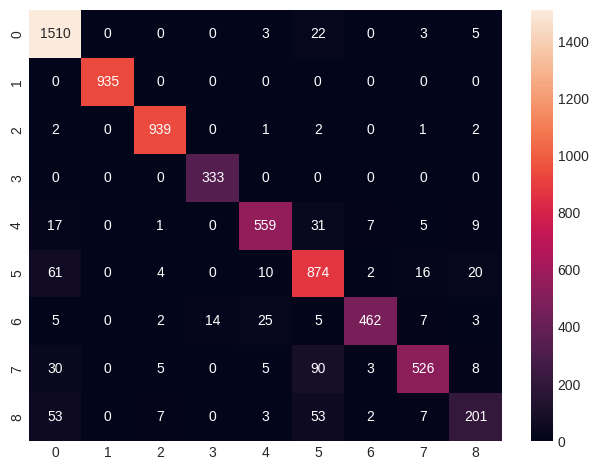

In [ ]:
sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_task1.argmax(1)),annot=True,fmt="d")